# Physics Informed Neural Networks (PINNs) for 1D Heat Equation

## 1. Introduction
In this workbook, we would be training a physics informed neural network model for 1D Heat equation. In specific, we will solve:

$\frac{\partial{u}}{\partial{t}} - \nu\nabla^{2} u(x) = f(x,t)$, where $x \in [-1,1]$, and $t \in (0,1]$


We will use the concept of PINNs, where the input to the neural network is $x, t$ and the output of the network is $u(x,t)$. Loss function is evaluated by enforcing the PDE and the boundary conditions.

Physics informed neural networks is made of a dense neural network that takes in the $(x,t)$ points in the domain and learns the physics from it using PDEs such as the one just above. 

The architecture of the network looks something like this:

![](https://www.researchgate.net/profile/Zhen-Li-105/publication/335990167/figure/fig1/AS:806502679982080@1569296631121/Schematic-of-a-physics-informed-neural-network-PINN-where-the-loss-function-of-PINN.ppm)

We will use the concept of PINNs, where the input to the neural network is $(x, t)$ and the output of the network is $u(x,t)$. Loss function is evaluated by enforcing the PDE and the boundary conditions.

We will begin the workbook with few imports and creating some helper functions

## 2. Imports and helper functions

* **deepxde**    - library for solving forward and inverse problems using PINNs
* **numpy**      - library for working multi-dimensional arrays and matrices
* **matplotlib** - library for data visualization

In [1]:
#import tensorflow as tf
#tf.version.VERSION

In [2]:
#!pip install --upgrade tensorflow

In [3]:
!pip install deepxde

In [4]:
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
import time 
import matplotlib.pyplot as plt
t0 = time.time()

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



## Helper function to plot $u(x,t)$

In [5]:
def plot(geom_time,data,name):
    plt.figure()
    plt.scatter(geom_time[:,0], geom_time[:,1],s = 20, c=np.reshape(data, (len(data),)), cmap='jet')
    plt.colorbar()
    plt.xlabel('x domain')
    plt.ylabel('time domain')
    plt.title(name)
    plt.show()

## Functions used to calcuate neural network loss

PDE: $pde(x,y) : \frac{\partial{u}}{\partial{t}} - \nu\nabla^{2} u(x) =0$, where $\nu = 0.3$ 

Boundary conditions $func(x): \sin(\pi x)e^{x}$

Deepxde provides help functions to compute first and second derivatives

_dde.grad.jacobian_ is used to compute Jacobian matrix $J: J[i][j] = \frac{dy_i}{dx_j}$, where $i,j=0,…,dim_x-1$

_dde.grad.Hessian_ is used to compute Hessian matrix $H: H[i][j] = \frac{d^2y}{dx_i dx_j}$, where $i,j=0,…,dim_x-1$

In [6]:
def pde(x, y):
#    dy_t = tf.gradients(y, x[:, 1:2])[0]
    dy_t = tf.gradients(y, x)[0][:, 1:2]
#    dy_x = tf.gradients(y, x[:, 0:1])[0]
    dy_x = tf.gradients(y, x)[0][:, 0:1]
#    dy_xx= tf.gradients(dy_x, x[:, 0:1])[0]
    dy_xx= tf.gradients(dy_x, x)[0][:, 0:1]
#
    return (
        dy_t
        - dy_xx*0.3)
    

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

## 2. initialization
Define geometry and time horizons for simulation

In [7]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Define boundary conditions and initial conditions

In [8]:
bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)

Create data points needed for building the model

In [9]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=4000,
    num_boundary=2000,
    num_initial=1000,
    solution=func,
    num_test=1000,
)

### Steps in building the model 

- Define the number of layers and neurons per layer in the neural network
- Define activation function on these layers _tanh_
- Define function for initial weights for training _Glorot uniform_
- Train the network using Adam optimizer with learning rate of 0.001

In [10]:
layer_size = [2] + [32] * 3 + [1]

activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.035974 s



2022-05-16 10:46:47.345801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 10:46:47.381102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 10:46:47.381625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 10:46:47.382833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

'compile' took 1.008428 s



## 3. Training


In [11]:
t1 = time.time()

losshistory, train_state = model.train(epochs=3000)

t2 = time.time()
print("training time:",(t2-t1))

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.85e-02, 1.75e-02, 4.73e-01]    [4.51e-02, 1.75e-02, 4.73e-01]    [1.00e+00]    
1000      [1.21e-03, 1.26e-03, 8.97e-04]    [1.01e-03, 1.26e-03, 8.97e-04]    [2.91e-01]    
2000      [2.97e-04, 6.84e-05, 7.41e-05]    [3.24e-04, 6.84e-05, 7.41e-05]    [2.83e-01]    
3000      [1.04e-04, 1.62e-05, 1.44e-05]    [1.21e-04, 1.62e-05, 1.44e-05]    [2.81e-01]    

Best model at step 3000:
  train loss: 1.35e-04
  test loss: 1.51e-04
  test metric: [2.81e-01]

'train' took 11.339890 s

training time: 11.340286016464233


## 4. Post-training Visualization

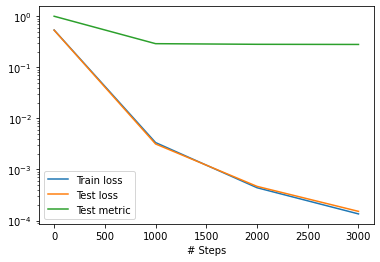

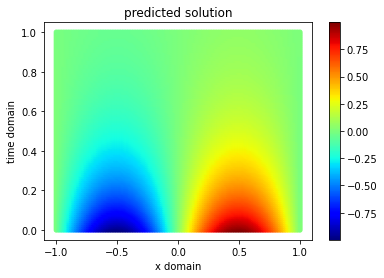

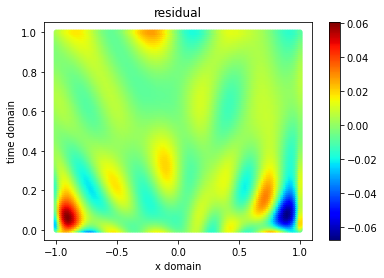

total time
12.544098377227783


In [12]:
dde.postprocessing.plot_loss_history(losshistory)
plt.show()


x_data = np.linspace(-1,1,num = 100)
t_data = np.linspace(0,1,num = 100)
test_x , test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain,operator=pde)



plot(test_domain,predicted_solution,"predicted solution")


plot(test_domain,residual,"residual")


print("total time")
print(t2-t0)